# Test

In [2]:
%load_ext autoreload
%autoreload 2

### Import datasets

Import datasets using functions from src/data/data.py. Datasets are downloaded from huggingface and stored in /data. Once downloaded, datasets are loaded locally.

Run ```pip install -e .``` if module importing isn't working.

In [16]:
from src.data.data import get_in_domain, get_out_domain
from src.data.data import get_random_subsets

in_domain_train, in_domain_test = get_in_domain()
out_domain = get_out_domain()

print(f"In domain:\n{in_domain_train}")
print(in_domain_train[0])

print(f"Out of domain:\n{out_domain}")
print(out_domain[10])

# get_random_subsets(in_domain)

In domain:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261802
})
{'premise': 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him', 'hypothesis': 'You lose the things to the following level if the people recall.', 'label': 0, 'idx': 1}
Out of domain:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 10000
})
{'premise': 'The president avoided the athlete .', 'hypothesis': 'The athlete avoided the president .', 'label': 1, 'parse_premise': '(ROOT (S (NP (DT The) (NN president)) (VP (VBD avoided) (NP (DT the) (NN athlete))) (. .)))', 'parse_hypothesis': '(ROOT (S (NP (DT The) (NN at

### Import models

Import models using methods from src/models/opt.py. Models are downloaded from huggingface and stored in /models/pretrained. Once downloaded, models are loaded locally.

In [22]:
from src.model.model import get_model, download_model

# Get SequenceClassification models
model_opt125, tokenizer_opt125 = get_model(model_name='opt-125m', model_type='SequenceClassification', pretrained=True)
model_opt350, tokenizer_opt350 = get_model(model_name='opt-350m', model_type='SequenceClassification', pretrained=True)

# Get CasualLM models
# model_opt125_causal, tokenizer_opt125_causal = get_model(model_name='opt-125m', model_type='CausalLM', pretrained=True)
# model_opt350_causal, tokenizer_opt350_causal = get_model(model_name='opt-350m', model_type='CausalLM', pretrained=True)

### Few-shot finetuning

Perform few-shot fine-tuning using the fine_tune method from /src/finetuners/fewshot.py. This method requires model, tokenizers, and datasets to be passed in as parameters. It returns training and evaluation metrics.

In [38]:
from src.finetuners.fewshot import fine_tune
import json

train_dataset = in_domain_train.select(range(2))
eval_dataset_in = in_domain_test.select(range(2))
eval_dataset_out = out_domain.select(range(2))

combined_metrics, training_history = fine_tune(model=model_opt125, 
                                               tokenizer=tokenizer_opt125, 
                                               train_dataset=train_dataset, 
                                               eval_dataset_in=eval_dataset_in, 
                                               eval_dataset_out=eval_dataset_out, 
                                               val_in_training=False,
                                               verbose=True, 
                                               disable_tqdm=True)

print(f"Metrics:\n{json.dumps(combined_metrics, indent=4)}")
print(f"Training history:\n{json.dumps(training_history, indent=4)}")

{'train_runtime': 8.9916, 'train_samples_per_second': 8.897, 'train_steps_per_second': 4.449, 'train_loss': 0.0, 'epoch': 40.0, 'train_peak_memory_gb': 2.501376152038574}
{'epoch': 40.0, 'eval_in_loss': 6.332043170928955, 'eval_in_accuracy': 0.5, 'eval_in_runtime': 4.1357, 'eval_in_samples_per_second': 0.484, 'eval_in_steps_per_second': 0.242, 'eval_in_peak_memory_gb': 1.4232711791992188}
{'epoch': 40.0, 'eval_out_loss': 12.384649276733398, 'eval_out_accuracy': 0.0, 'eval_out_runtime': 4.1957, 'eval_out_samples_per_second': 0.477, 'eval_out_steps_per_second': 0.238, 'eval_out_peak_memory_gb': 1.4232711791992188}
{
    "train_runtime": 8.9916,
    "train_samples_per_second": 8.897,
    "train_steps_per_second": 4.449,
    "train_loss": 0.0,
    "epoch": 40.0,
    "train_peak_memory_gb": 2.501376152038574,
    "eval_in_loss": 6.332043170928955,
    "eval_in_accuracy": 0.5,
    "eval_in_runtime": 4.1357,
    "eval_in_samples_per_second": 0.484,
    "eval_in_steps_per_second": 0.242,
    "

### Batch few-shot finetuning

Perform batch few-shot fine-tuning using batch_fine_tune from /src/finetuners/fewshot.py. This method only requires model_name and training and eval datasets. The selected model is loaded from /models/pretrained for each trial to prevent cumulative fine-tuning. sample_sizes corresponds to the number of shots used for each trial. Each trial is trained and evaluated using data randomly selected by get_random_subsets from /src/utils.py. Results are written to a csv in /logs.

In [24]:
import json
from src.finetuners.fewshot import batch_fine_tune
from src.data.data import get_random_subsets

# Generate training and evaluation datasets. These should be used for all fine-tuning methods to ensure consistency. np.random should be seeded before this.
train_datasets, eval_dataset_in, eval_dataset_out = get_random_subsets(train_dataset=in_domain_train, 
                                                                       eval_dataset_in=in_domain_test, 
                                                                       eval_dataset_out=out_domain, 
                                                                       train_sample_sizes=[2, 4, 6, 8, 16],#[2, 16, 32, 64, 128], # [2, 4],
                                                                       num_trials=10,   # 5
                                                                       eval_sample_size=50) # 10

results, training_histories = batch_fine_tune(model_name='opt-125m', train_datasets=train_datasets, eval_dataset_in=eval_dataset_in, eval_dataset_out=eval_dataset_out)

print(json.dumps(results, indent=4))
print(json.dumps(training_histories, indent=4))

2-shot:   0%|          | 0/10 [00:00<?, ?it/s]

4-shot:   0%|          | 0/10 [00:00<?, ?it/s]

6-shot:   0%|          | 0/10 [00:00<?, ?it/s]

8-shot:   0%|          | 0/10 [00:00<?, ?it/s]

16-shot:   0%|          | 0/10 [00:00<?, ?it/s]

{
    "2": [
        {
            "train_runtime": 166.14,
            "train_samples_per_second": 0.482,
            "train_steps_per_second": 0.241,
            "total_flos": 20903740047360.0,
            "train_loss": 0.07343715172901284,
            "epoch": 40.0,
            "train_peak_memory_gb": 3.8894286155700684,
            "eval_in_loss": 1.0677809715270996,
            "eval_in_accuracy": 0.42,
            "eval_in_runtime": 4.9893,
            "eval_in_samples_per_second": 10.021,
            "eval_in_steps_per_second": 1.403,
            "eval_in_peak_memory_gb": 3.34763240814209,
            "eval_out_loss": 0.691834032535553,
            "eval_out_accuracy": 0.56,
            "eval_out_runtime": 4.944,
            "eval_out_samples_per_second": 10.113,
            "eval_out_steps_per_second": 1.416,
            "eval_out_peak_memory_gb": 3.34763240814209
        },
        {
            "train_runtime": 161.8745,
            "train_samples_per_second": 0.494,
        

### Zero-shot inference
Perform inference on un fine-tuned models as a baseline for comparison with fine-tuned models.

In [23]:
from src.finetuners.zeroshot import evaluate
import json

eval_dataset_in = in_domain_test.select(range(2))
eval_dataset_out = out_domain.select(range(2))

combined_metrics = evaluate(model=model_opt125, 
                            tokenizer=tokenizer_opt125, 
                            eval_dataset_in=eval_dataset_in, 
                            eval_dataset_out=eval_dataset_out, 
                            verbose=True, 
                            disable_tqdm=True)

print(f"Metrics:\n{json.dumps(combined_metrics, indent=4)}")

{'eval_in_loss': 0.7932267189025879, 'eval_in_accuracy': 0.5, 'eval_in_runtime': 3.9201, 'eval_in_samples_per_second': 0.51, 'eval_in_steps_per_second': 0.255}
{'eval_out_loss': 0.9104948043823242, 'eval_out_accuracy': 0.0, 'eval_out_runtime': 3.6967, 'eval_out_samples_per_second': 0.541, 'eval_out_steps_per_second': 0.271}
Metrics:
{
    "eval_in_loss": 0.7932267189025879,
    "eval_in_accuracy": 0.5,
    "eval_in_runtime": 3.9201,
    "eval_in_samples_per_second": 0.51,
    "eval_in_steps_per_second": 0.255,
    "eval_out_loss": 0.9104948043823242,
    "eval_out_accuracy": 0.0,
    "eval_out_runtime": 3.6967,
    "eval_out_samples_per_second": 0.541,
    "eval_out_steps_per_second": 0.271
}


### Plot in domain vs out of domain metrics

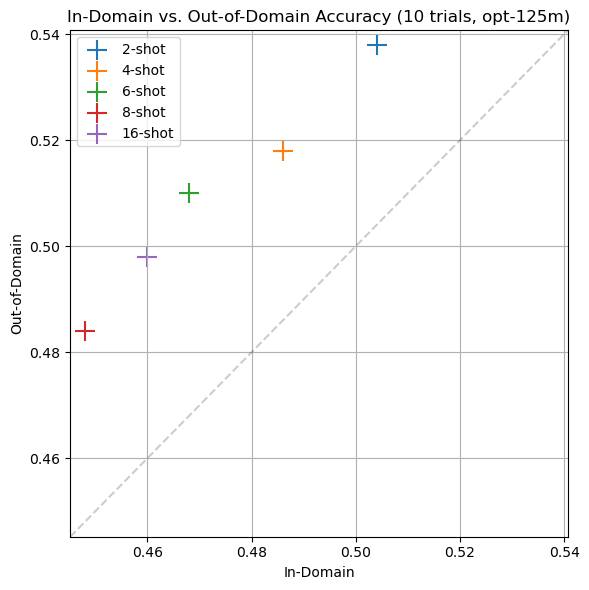

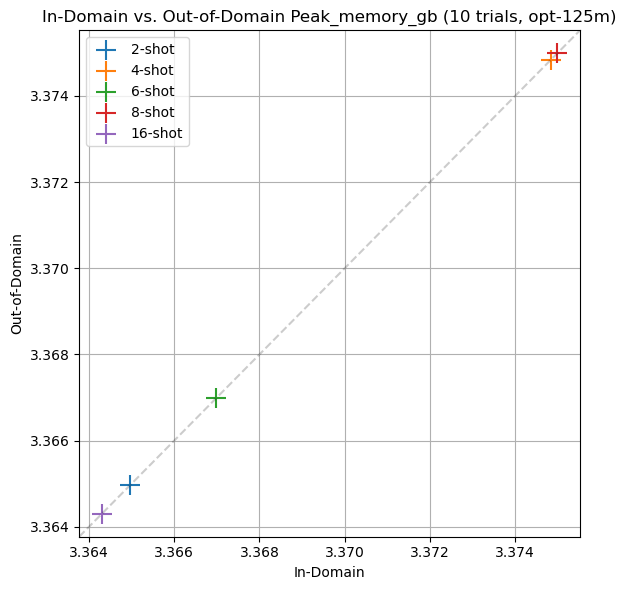

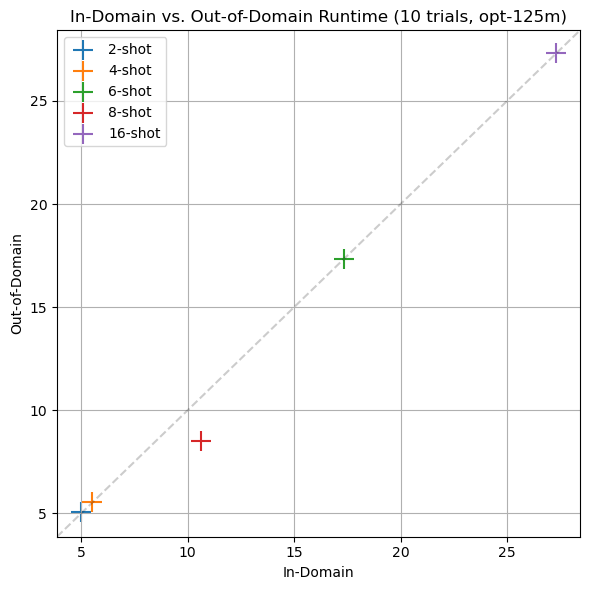

In [29]:
from src.visualization.plot import plot_in_out_domain

plot_in_out_domain(logfile='opt-125m_fewshot_metrics_2_4_6_8_16.csv', metric='accuracy')
plot_in_out_domain(logfile='opt-125m_fewshot_metrics_2_4_6_8_16.csv', metric='peak_memory_gb')
plot_in_out_domain(logfile='opt-125m_fewshot_metrics_2_4_6_8_16.csv', metric='runtime')

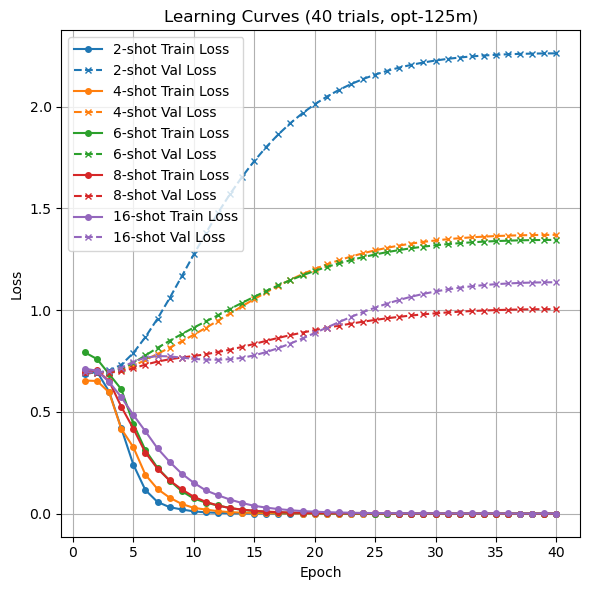

<Figure size 600x600 with 0 Axes>

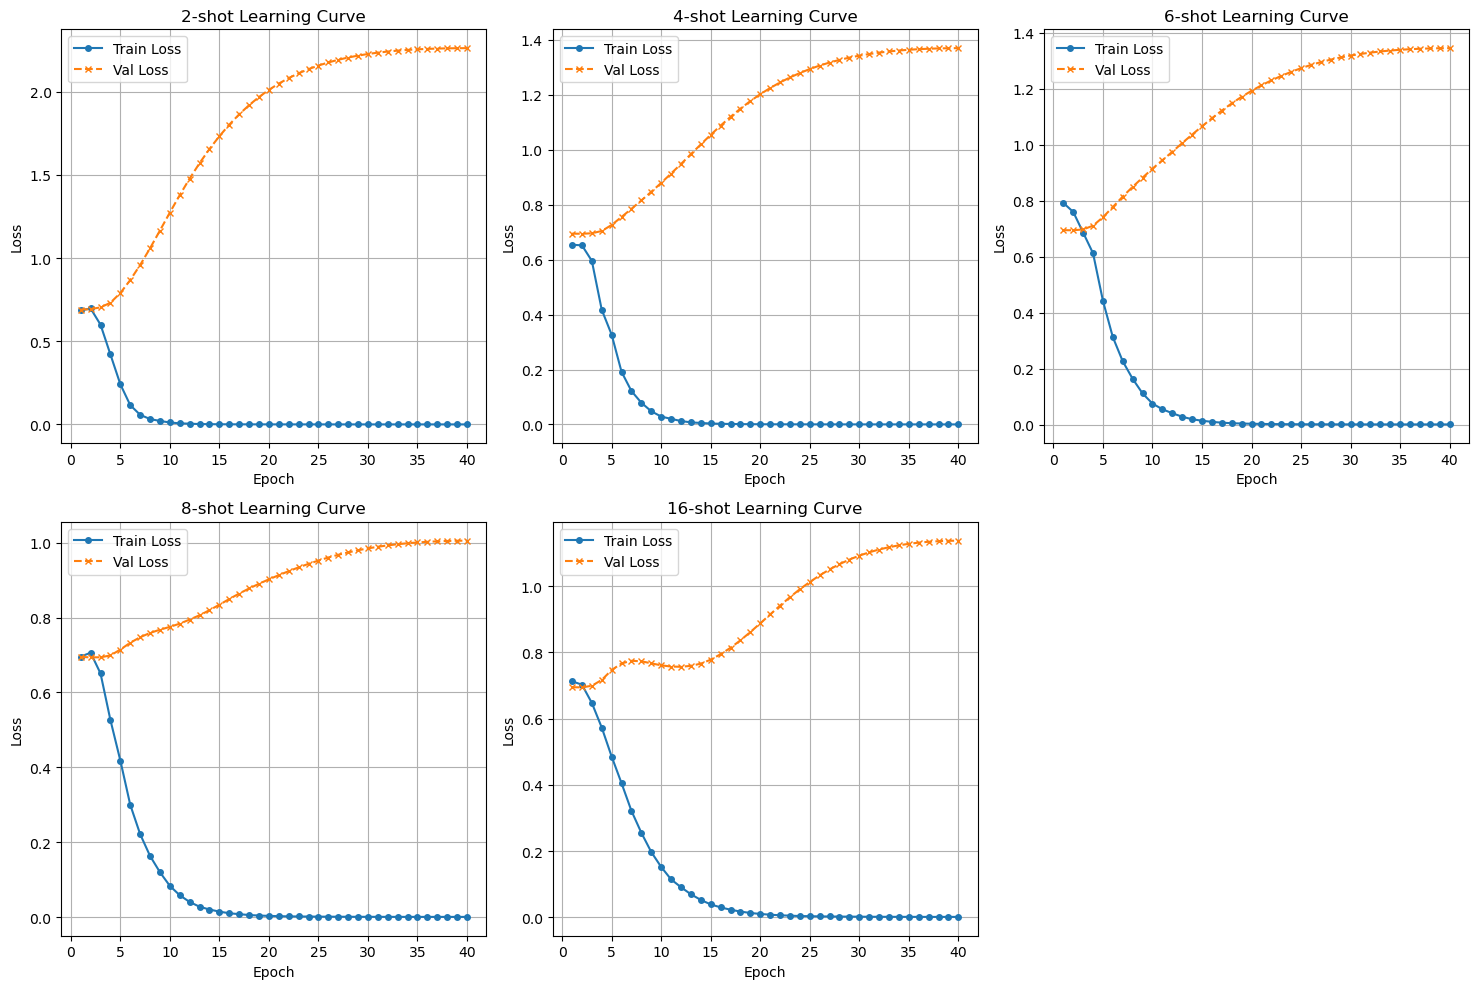

In [26]:
from src.visualization.plot import plot_learning_curves

plot_learning_curves(logfile='opt-125m_fewshot_training_history_2_4_6_8_16.csv', subplot=False)
plot_learning_curves(logfile='opt-125m_fewshot_training_history_2_4_6_8_16.csv', subplot=True)